In [2]:
import pandas as pd
import xgboost as xgb
import numpy as np

# Machine Learning 
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler


# Models
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import datetime as dt

# FE
from tsfresh import extract_features, select_features, extract_relevant_features
from tsfresh.utilities.dataframe_functions import impute
from sklearn.inspection import permutation_importance

In [202]:
#####################
# Feature Engineering
#####################

def get_tsfresh_features(data):
    # Get statistic features using library TSFRESH 
    # Thanks to https://www.kaggle.com/code/vbmokin/btc-growth-forecasting-with-advanced-fe-for-ohlc
    
    data = data.reset_index(drop=False).reset_index(drop=False)
    
    # Extract features
    extracted_features = extract_features(data, column_id="datetime", column_sort="datetime")
    
    # Drop features with NaN
    extracted_features_clean = extracted_features.dropna(axis=1, how='all').reset_index(drop=True)
    
    # Drop features with constants
    cols_std_zero  = []
    for col in extracted_features_clean.columns:
        if extracted_features_clean[col].std()==0:
            cols_std_zero.append(col)
    extracted_features_clean = extracted_features_clean.drop(columns = cols_std_zero)

    extracted_features_clean['datetime'] = data['datetime']   # For the merging
    
    return extracted_features_clean

def get_add_features(df_feat):
    # FE for data as row of DataFrame
    # Thanks to https://www.kaggle.com/code/vbmokin/g-research-crypto-forecasting-baseline-fe
    
    # Two new features from the competition tutorial
    df_feat['upper_shadow'] = df_feat['high'] - np.maximum(df_feat['close'], df_feat['open'])
    df_feat['lower_shadow'] = np.minimum(df_feat['close'], df_feat['open']) - df_feat['low']
    df_feat['high2low'] = (df_feat['high'] / df_feat['low']).replace([np.inf, -np.inf, np.nan], 0.)
    
    return df_feat

#####################
# Data Preprocessing
#####################

def cut_data(df, y, num_start, num_end):
    # Cutting dataframe df and array or list for [num_start, num_end-1]        
    df2 = df[num_start:(num_end+1)]
    y2 = y[num_start:(num_end+1)] if y is not None else None
    return df2, y2

def get_target_mf(df, forecasting_days, predict_delay, col='close'):
    # Get target as difference of the df[col] 
    # Returns target which is shifted for forecasting_days days in the dataframe df
    # "Close" -> "Close_diff" -> "Target" 
    col_diff = f"{col}_diff"
    df[col_diff] = df['close'].diff()
    df['target'] = df[col_diff].shift(-predict_delay)
    df = df.drop(columns=[col_diff]).dropna()
    
    return df

def get_train_valid_test_ts(df, forecasting_days, target='close'):
    # Get training, validation and test datasets with target for Time Series models
    
    # Data prepairing
    df = df.dropna(how="any").reset_index(drop=True)
    df = df[['datetime', 'close']]
    df.columns = ['ds', 'y']        
    y = None

    # Data smoothing
#     df.index = df.ds
#     df = df.drop(columns=['ds'])
#     df['y'] = df['y'].rolling(7).mean()
#     df = df.dropna().reset_index(drop=False)
    
    N = len(df)
    train, _ = cut_data(df, y, 0, N-2*forecasting_days-1)
    valid, _ = cut_data(df, y, N-2*forecasting_days, N-forecasting_days-1)
    test, _ = cut_data(df, y, N-forecasting_days, N)
    
    # Train+valid - for optimal model training
    train_valid = pd.concat([train, valid])

    print(f'Origin dataset has {len(df)} rows and {len(df.columns)} features')
    print(f'Get training dataset with {len(train)} rows')
    print(f'Get validation dataset with {len(valid)} rows')
    print(f'Get test dataset with {len(test)} rows')
    
    return train, valid, test, train_valid

def get_train_valid_test_mf(df, forecasting_days, target='target', binaire=True):
    # Get training, validation and test datasets with target for multi-features ML models
    
    df = df.drop(columns = ['datetime']).dropna(how="any").reset_index(drop=True)
    
    # Save and drop target        
    y = df.pop(target)

    # Get starting points for the recovering "Close" from "Close_diff_shigted"
    N = len(df)
    #print(f"Total - {N}, Valid start index = {N-forecasting_days-1}, Test start index = {N-1}")
    start_points = {'valid_start_point' : df.loc[N-forecasting_days-1, 'close'],
                    'test_start_point' : df.loc[N-1, 'close']}

    # Standartization data
    scaler = StandardScaler()
    df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
    
    
    train, ytrain = cut_data(df.copy(), y, 0, N-2*forecasting_days-1)
    valid, yvalid = cut_data(df.copy(), y, N-2*forecasting_days, N-forecasting_days-1)
    test, ytest = cut_data(df.copy(), y, N-forecasting_days, N)

    if binaire:
        ytrain = (ytrain > 0).astype(int)
        yvalid = (yvalid > 0).astype(int)
        ytest = (ytest > 0).astype(int)

    # Train+valid - for optimal model training
    train_valid = pd.concat([train, valid])
    y_train_valid = pd.concat([ytrain, yvalid])

    print(f'Origin dataset has {len(df)} rows and {len(df.columns)} features')
    print(f'Get training dataset with {len(train)} rows')
    print(f'Get validation dataset with {len(valid)} rows')
    print(f'Get test dataset with {len(test)} rows')
    
    return train, ytrain, valid, yvalid, test, ytest, train_valid, y_train_valid, start_points

def calc_metrics(type_score, list_true, list_pred):
    # Calculation score with type=type_score for list_true and list_pred 
    if type_score=='r2_score':
        score = r2_score(list_true, list_pred)
    elif type_score=='rmse':
        score = mean_squared_error(list_true, list_pred, squared=False)
    elif type_score=='mape':
        score = mean_absolute_percentage_error(list_true, list_pred)
    return score

def result_add_metrics(result, n, y_true, y_pred):
    # Calculation and addition metrics into dataframe result[n,:]
    
    result.loc[n,'r2_score'] = calc_metrics('r2_score', y_true, y_pred)
    result.loc[n,'rmse'] = calc_metrics('rmse', y_true, y_pred)      # in coins
    result.loc[n,'mape'] = 100*calc_metrics('mape', y_true, y_pred)  # in %
    
    return result

#####################
# Backtesting
#####################

def calculate_strategy(df, preds):
    df_backtest = df[len(df)-len(preds):].reset_index(drop=True).assign(preds=preds)[['open','close', 'high', 'low', 'close_diff', 'preds']]

    # Add the 'datetime' index
    df_backtest = df_backtest.set_index(df[len(df)-len(preds):]['datetime'])


    # Calculate the percentage change of 'close' to see if it goes up or down
    df_backtest['return'] = df_backtest['close'].pct_change()

    # Replace 0 with -1 in 'preds'
    df_backtest['preds_short'] = df_backtest['preds'].replace(0, -1)

    # Create a 'strategy return' column which is equal to the prediction multiplied by the return
    df_backtest['long_strategy_return'] = df_backtest['preds'] * df_backtest['return']
    df_backtest['long_short_strategy_return'] = df_backtest['preds_short'] * df_backtest['return']

    # Calculate cumulative product for 'buy_and_hold', 'long_strategy', and 'long_short_strategy'
    df_backtest["buy_and_hold"] = (1 + df_backtest['return']).cumprod()
    df_backtest["long_strategy"] = (1 + df_backtest['long_strategy_return']).cumprod()
    df_backtest["long_short_strategy"] = (1 + df_backtest['long_short_strategy_return']).cumprod()

    return df_backtest

In [206]:
# Choose settings

forecasting_days = 300
predict_delay = 1

start_date = '2020-01-01'
end_date = dt.datetime.now().strftime('%Y-%m-%d')

timeframe = 'D1'
symbol = 'BTCUSDT'

# Set le nombre de temps backtest qu'on veut pour le modèle

df = pd.read_csv(f'data/archive/{timeframe}/{symbol}_{timeframe}.csv')

# Met datetime en index
df['datetime'] = pd.to_datetime(df['datetime'])
df = df[(df['datetime'] >= start_date) & (df['datetime'] <= end_date)]
df.set_index('datetime', inplace=True)

df['close_diff'] = df['close'].diff()
df = df.dropna()

# FE with TSFRESH
extracted_features_clean = get_tsfresh_features(df[['close']])

# Get all features
df = pd.merge(df, extracted_features_clean, how='left', on='datetime')

# FE - add features
df = get_add_features(df)

# Target
df2 = get_target_mf(df, forecasting_days, predict_delay, col='close')

# Get train, valid, test
train, ytrain, valid, yvalid, test, ytest, train_valid, y_train_valid, start_points = get_train_valid_test_mf(df2, forecasting_days)

# DMatrix for XGBoost
dtrain = xgb.DMatrix(train, label=ytrain)
dvalid = xgb.DMatrix(valid, label=yvalid)
dtest = xgb.DMatrix(test, label=ytest)
dtrain_valid = xgb.DMatrix(train_valid, label=y_train_valid)

# Model

# XGBoost

import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Initialize the DataFrame to store the results
results = pd.DataFrame(columns=["n", "learning_rate", "max_depth", "rmse", "accuracy"])

# Define the values to test
n_values = [300, 400, 500]
learning_rate_values = [0.1, 0.2, 0.3, 0.4, 0.5]
max_depth_values = [3, 4, 5, 6, 10, 15]

# Loop over the values
for n in n_values:
    for learning_rate in learning_rate_values:
        for max_depth in max_depth_values:
            params = {"objective": "multi:softmax","num_class": 2, "tree_method": "hist",
                      "learning_rate": learning_rate, "max_depth": max_depth,
                      "gamma": 0, "subsample": 1, "colsample_bytree": 1,
                      "alpha": 0, "lambda": 1,"random_state": 0}

            evals = [(dvalid, "validation"), (dtrain, "train")]

            model = xgb.train(
               params=params,
               dtrain=dtrain,
               num_boost_round=n,
               evals=evals,
               verbose_eval=0
            )
            preds = model.predict(dvalid)
            rmse = mean_squared_error(yvalid, preds, squared=False)
            accuracy = accuracy_score(yvalid, preds.round())

            # Append the results to the DataFrame
            results = pd.concat([results, pd.DataFrame([{"n": n, "learning_rate": learning_rate, "max_depth": max_depth, 
                                      "rmse": rmse, "accuracy": accuracy}])], ignore_index=True)

# Print the DataFrame
print(results)


Feature Extraction: 100%|██████████| 25/25 [00:07<00:00,  3.33it/s]


Origin dataset has 1516 rows and 58 features
Get training dataset with 916 rows
Get validation dataset with 300 rows
Get test dataset with 300 rows


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


      n  learning_rate max_depth      rmse  accuracy
0   300            0.1         3  0.683130  0.533333
1   300            0.1         4  0.642910  0.586667
2   300            0.1         5  0.685565  0.530000
3   300            0.1         6  0.655744  0.570000
4   300            0.1        10  0.650641  0.576667
..  ...            ...       ...       ...       ...
85  500            0.5         4  0.640312  0.590000
86  500            0.5         5  0.680686  0.536667
87  500            0.5         6  0.653197  0.573333
88  500            0.5        10  0.642910  0.586667
89  500            0.5        15  0.621825  0.613333

[90 rows x 5 columns]


In [207]:
# Find the best parameters
best_params = results.loc[results["rmse"].idxmin()]
print(best_params)

# Train the model with the best parameters
params = {"objective": "multi:softmax","num_class": 2, "tree_method": "hist",
          "learning_rate": best_params["learning_rate"], "max_depth": best_params["max_depth"],
          "gamma": 0, "subsample": 1, "colsample_bytree": 1,
          "alpha": 0, "lambda": 1,"random_state": 0}

evals = [(dvalid, "validation"), (dtrain, "train")]

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=int(best_params["n"]),
    evals=evals,
    verbose_eval=0
    )

# Make predictions
preds = model.predict(dtest)
rmse = mean_squared_error(ytest, preds, squared=False)
accuracy = accuracy_score(ytest, preds.round())

# Print the results
print(f"RMSE of the best model: {rmse:.3f}")
print(f"Accuracy of the best model: {accuracy:.3f}")



n                     300
learning_rate         0.5
max_depth              15
rmse             0.616441
accuracy             0.62
Name: 29, dtype: object
RMSE of the best model: 0.714
Accuracy of the best model: 0.490


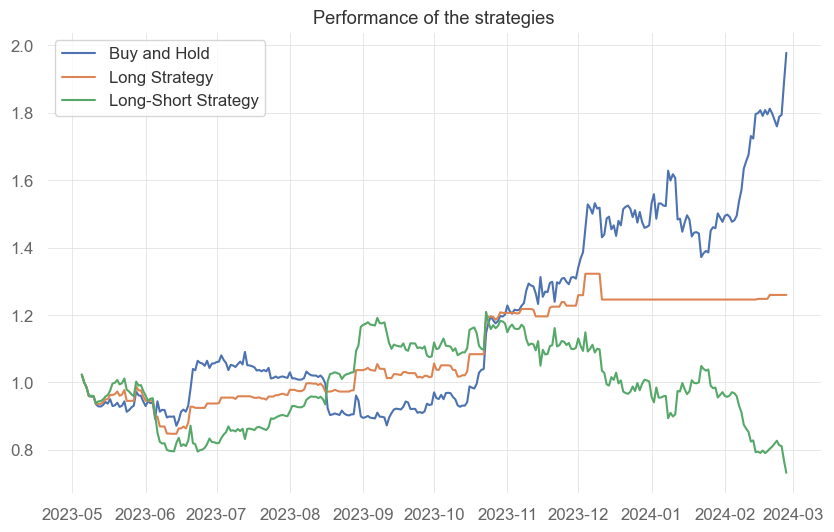

In [208]:
df_backtest = calculate_strategy(df, preds)

# Plot the performance of the strategies
plt.figure(figsize=(10, 6))
plt.plot(df_backtest["buy_and_hold"], label="Buy and Hold")
plt.plot(df_backtest["long_strategy"], label="Long Strategy")
plt.plot(df_backtest["long_short_strategy"], label="Long-Short Strategy")
plt.title("Performance of the strategies")
plt.legend()
plt.show()



The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2023-05-07   2023-05-07
End Period                 2024-02-27   2024-02-27
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          97.72%       -26.82%
CAGR﹪                     78.66%       -23.35%

Sharpe                     1.88         -0.61
Prob. Sharpe Ratio         98.11%       25.62%
Smart Sharpe               1.76         -0.57
Sortino                    3.09         -0.86
Smart Sortino              2.89         -0.8
Sortino/√2                 2.18         -0.61
Smart Sortino/√2           2.04         -0.57
Omega                      0.89         0.89

Max Drawdown               -20.0%       -39.48%
Longest DD Days            101          127
Volatility (ann.)          33.82%       34.03%
R^2                        0.12         0.12
Information Ratio          -0.1         -0.1
Calmar      

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-10-24,2024-02-27,2024-02-27,127,-39.475051,-34.639922
2,2023-05-24,2023-06-23,2023-08-17,86,-21.417626,-21.346004
3,2023-09-08,2023-09-29,2023-10-22,45,-9.749390,-9.562898
4,2023-05-08,2023-05-11,2023-05-17,10,-4.862364,-4.249917
5,2023-08-21,2023-08-23,2023-08-28,8,-1.950020,-1.012761


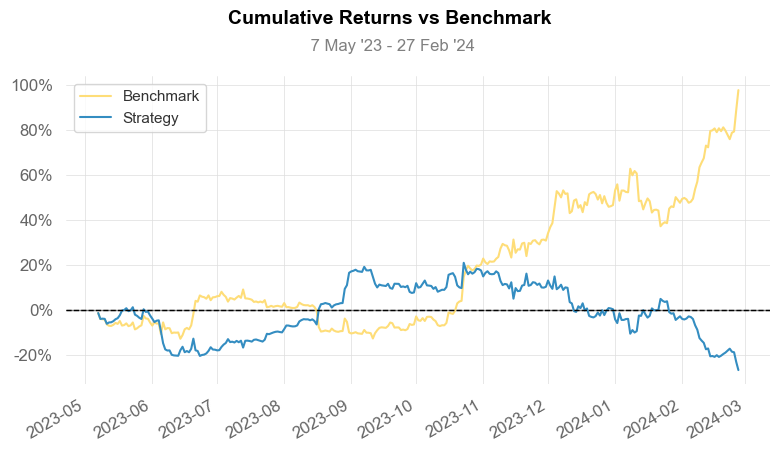

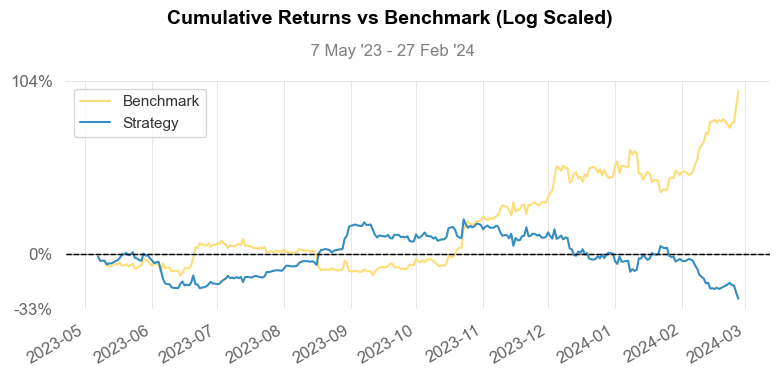

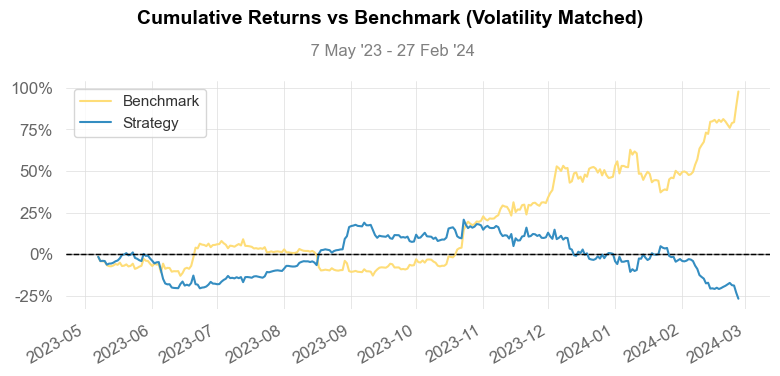

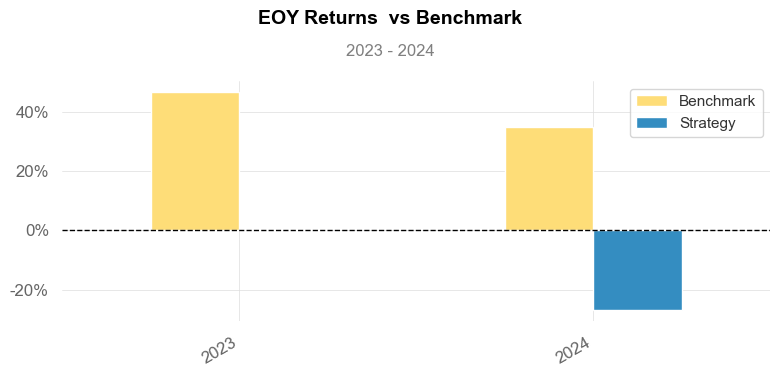

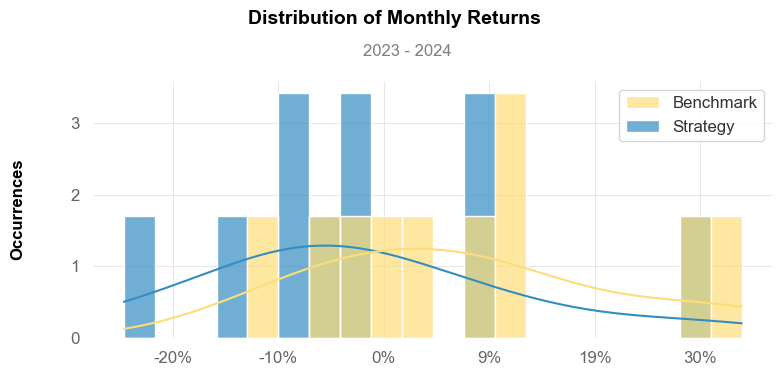

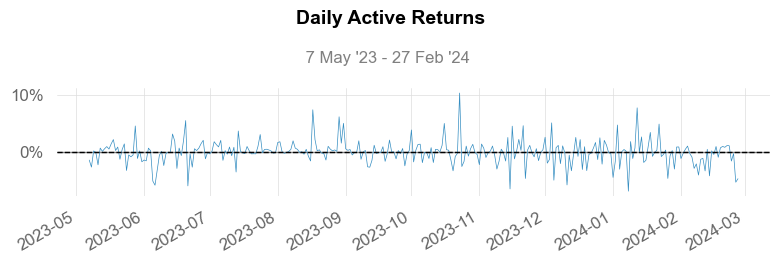

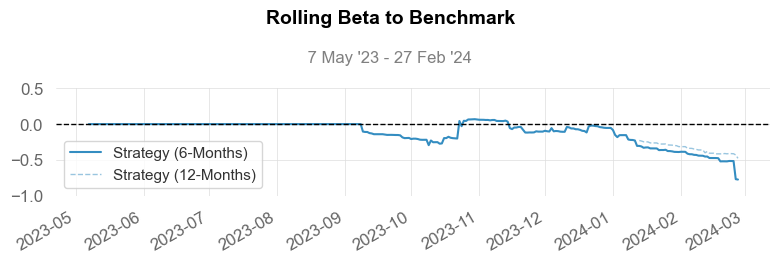

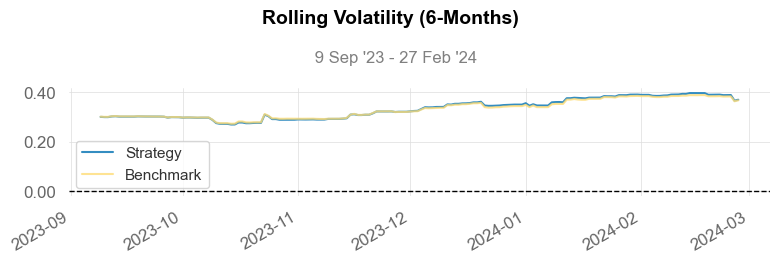

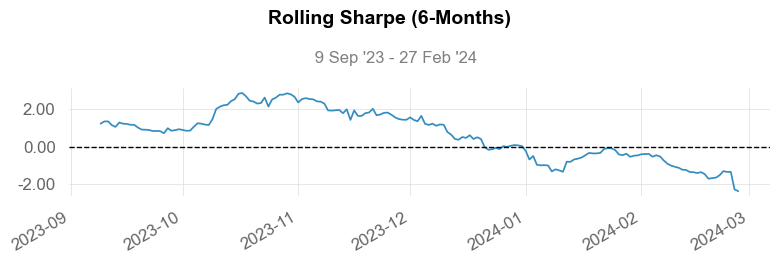

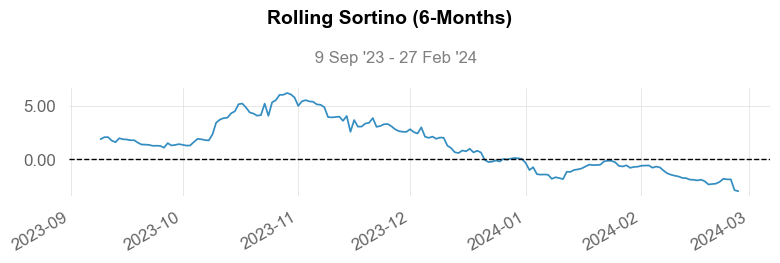

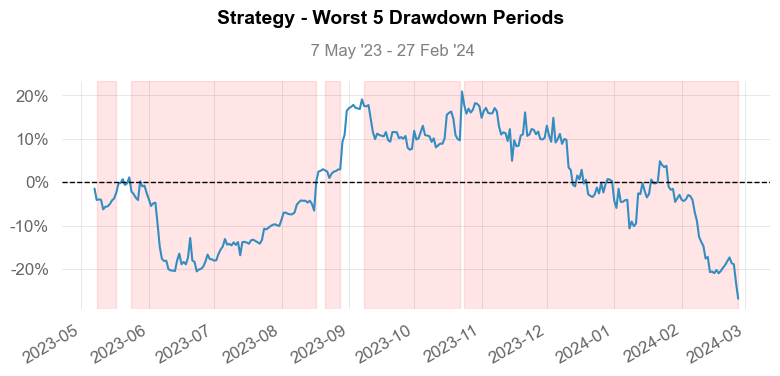

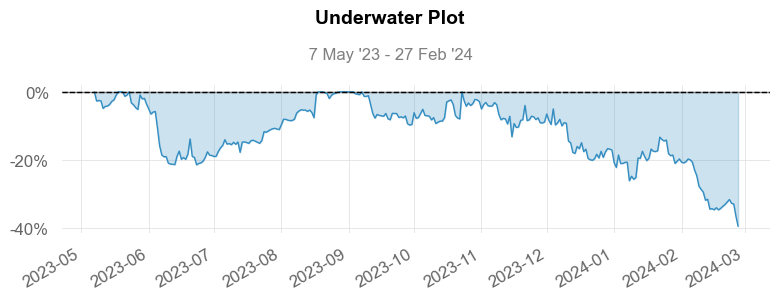

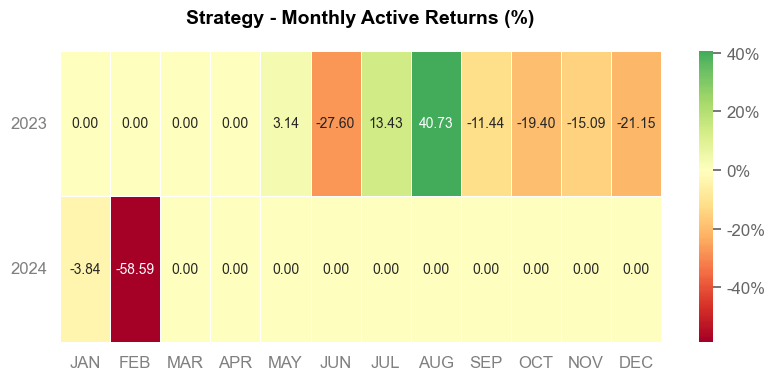

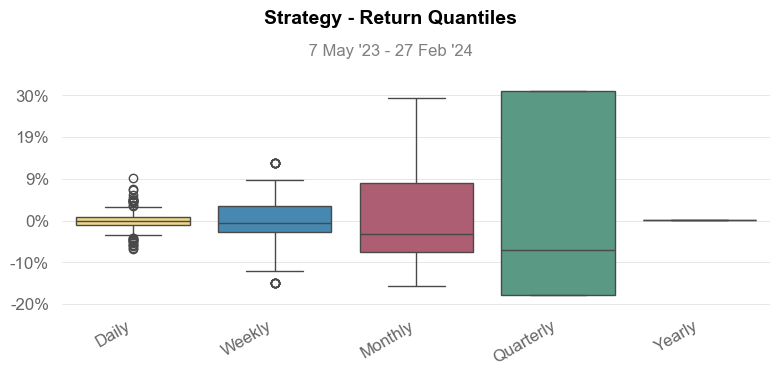

In [209]:
import quantstats as qs

# Calculate the performance of the strategies
qs.extend_pandas()
qs.reports.full(df_backtest["long_short_strategy"], df_backtest["buy_and_hold"])